# Import and check

In [1]:
import pandas as pd
import networkx as nx
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import matplotlib.pyplot as plt
import copy
import numpy as np
import random

In [2]:
train_df = pd.read_excel('data/train_scaled.xlsx')
validation_df = pd.read_excel('data/validation_scaled.xlsx')

In [3]:
def missing(data):
# Identify missing data
    missing_data = data.isnull().sum()
    missing_percent = (data.isnull().sum() / len(data)) * 100

    # Create a DataFrame for missing data
    missing_df = pd.DataFrame({
        'Total': missing_data,
        'Percent': missing_percent
    })
    # Display columns with missing values
    return missing_df[missing_df['Total'] > 0].sort_values(by="Total", ascending=False)

missing(train_df)

,Total,Percent


In [4]:
missing(validation_df)

,Total,Percent


In [5]:
train = train_df.copy()
validation = validation_df.copy()

In [6]:
target = train['target']

In [7]:
target.value_counts()

target
1    8515
0    4748
Name: count, dtype: int64

In [8]:
columns_to_drop = ['blue_fighter_weight', 'red_fighter_weight']

train = train.drop(columns=[col for col in columns_to_drop if col in train.columns])
validation = validation.drop(columns=[col for col in columns_to_drop if col in validation.columns])

# Symmetric GCN

In [21]:
def swap_red_blue_columns(df):
    """
    Swap red and blue columns in the dataframe
    
    Args:
        df: Original dataframe
        
    Returns:
        A new dataframe with red and blue columns swapped
    """
    # Create a copy of the dataframe
    df_mod = df.copy()
    
    # Identify columns that need to be swapped (those with 'red' or 'blue' in their names)
    red_cols = [col for col in df.columns if 'red' in col]
    blue_cols = [col for col in df.columns if 'blue' in col]
    
    # Create mapping for column renaming
    rename_dict = {}
    
    # For each red column, find the corresponding blue column
    for red_col in red_cols:
        # Replace 'red' with 'blue' to get the corresponding blue column name
        blue_col = red_col.replace('red', 'blue')
        
        # Check if the corresponding blue column exists
        if blue_col in blue_cols:
            # Add to rename dictionary (we'll do a two-step rename to avoid conflicts)
            rename_dict[red_col] = f"temp_{red_col}"
            rename_dict[blue_col] = f"temp_{blue_col}"
    
    # First step: rename to temporary names
    df_mod.rename(columns=rename_dict, inplace=True)
    
    # Second step: rename from temporary names to swapped names
    second_rename = {}
    for orig_col, temp_col in rename_dict.items():
        if 'red' in orig_col:
            # This was a red column, now should be blue
            second_rename[temp_col] = orig_col.replace('red', 'blue')
        else:
            # This was a blue column, now should be red
            second_rename[temp_col] = orig_col.replace('blue', 'red')
    
    df_mod.rename(columns=second_rename, inplace=True)
    
    # For target column, we need to invert it (1 becomes 0, 0 becomes 1)
    if 'target' in df_mod.columns:
        df_mod['target'] = 1 - df_mod['target']
    
    return df_mod


In [22]:
def verify_data_swapping():
    # Take a sample from original data
    sample = train.sample(5)
    swapped = swap_red_blue_columns(sample)
    
    print("Checking data augmentation for 5 random samples:")
    for i in range(len(sample)):
        orig = sample.iloc[i]
        swap = swapped.iloc[i]
        
        # Check fighter names swapped
        fighters_swapped = (orig['red_fighter_name'] == swap['blue_fighter_name'] and 
                            orig['blue_fighter_name'] == swap['red_fighter_name'])
        
        # Check target inverted
        target_inverted = (orig['target'] == 1 - swap['target'])
        
        # Check some feature columns
        feat_cols = [c for c in sample.columns if 'red' in c and c != 'red_fighter_name']
        sample_feat_cols = random.sample(feat_cols, min(3, len(feat_cols)))
        
        features_swapped = True
        for col in sample_feat_cols:
            blue_col = col.replace('red', 'blue')
            if abs(orig[col] - swap[blue_col]) > 1e-6:
                features_swapped = False
                print(f"Feature mismatch: {col}={orig[col]}, swapped {blue_col}={swap[blue_col]}")
        
        print(f"Sample {i+1}:")
        print(f"  Original: Red={orig['red_fighter_name']}, Blue={orig['blue_fighter_name']}, Target={orig['target']}")
        print(f"  Swapped: Red={swap['red_fighter_name']}, Blue={swap['blue_fighter_name']}, Target={swap['target']}")
        print(f"  Names swapped correctly: {fighters_swapped}")
        print(f"  Target inverted correctly: {target_inverted}")
        print(f"  Features swapped correctly: {features_swapped}")
        print()

verify_data_swapping()

Checking data augmentation for 5 random samples:
Sample 1:
  Original: Red=Alex Caceres, Blue=Sean Woodson, Target=0
  Swapped: Red=Sean Woodson, Blue=Alex Caceres, Target=1
  Names swapped correctly: True
  Target inverted correctly: True
  Features swapped correctly: True

Sample 2:
  Original: Red=Ashley Yoder, Blue=Amanda Cooper, Target=1
  Swapped: Red=Amanda Cooper, Blue=Ashley Yoder, Target=0
  Names swapped correctly: True
  Target inverted correctly: True
  Features swapped correctly: True

Sample 3:
  Original: Red=Rodrigo Damm, Blue=Rashid Magomedov, Target=0
  Swapped: Red=Rashid Magomedov, Blue=Rodrigo Damm, Target=1
  Names swapped correctly: True
  Target inverted correctly: True
  Features swapped correctly: True

Sample 4:
  Original: Red=Muhammad Mokaev, Blue=Manel Kape, Target=1
  Swapped: Red=Manel Kape, Blue=Muhammad Mokaev, Target=0
  Names swapped correctly: True
  Target inverted correctly: True
  Features swapped correctly: True

Sample 5:
  Original: Red=Randy

In [23]:
def augment_training_data(train_df):
    """
    Augment training data by adding swapped versions of each matchup
    """
    # Create swapped version of the training data
    train_swapped = swap_red_blue_columns(train_df)
    
    # Concatenate original and swapped data
    augmented_train = pd.concat([train_df, train_swapped], ignore_index=True)
    
    return augmented_train

In [24]:
def create_ufc_graph(df):
    G = nx.Graph()
    
    # Get unique fighters and create nodes
    fighters = set(df['red_fighter_name'].unique()) | set(df['blue_fighter_name'].unique())
    
    # Create nodes (no features needed)
    for fighter in fighters:
        G.add_node(fighter)
    
    # Get all columns except fighter names and event_date (will be used only for splitting)
    edge_feature_cols = [col for col in df.columns if col not in ['red_fighter_name', 'blue_fighter_name', 'event_date']]
    
    # Add edges with features
    for _, row in df.iterrows():
        red_fighter = row['red_fighter_name']
        blue_fighter = row['blue_fighter_name']
        
        # Create edge features dictionary
        edge_features = {}
        for col in edge_feature_cols:
            value = row[col]
            if isinstance(value, bool):
                edge_features[col] = float(value)
            elif isinstance(value, (int, float)):
                edge_features[col] = float(value)
            else:
                try:
                    edge_features[col] = float(value)
                except:
                    continue  # Skip features that can't be converted to float
        
        # Add event_date as metadata but not as a feature
        if 'event_date' in df.columns:
            edge_features['_event_date'] = row['event_date']  # Prefix with _ to indicate metadata
        
        G.add_edge(red_fighter, blue_fighter, **edge_features)
    
    return G, edge_feature_cols

In [25]:
def create_pytorch_geometric_data(G, edge_feature_cols):
    # Create node index mapping
    node_idx = {node: idx for idx, node in enumerate(G.nodes())}
    
    # Create edge index and edge features
    edge_index = []
    edge_features = []
    edge_dates = []  # To store dates for time-based splitting
    
    for u, v, data in G.edges(data=True):
        # Add edge indices (both directions since it's undirected)
        edge_index.append([node_idx[u], node_idx[v]])
        edge_index.append([node_idx[v], node_idx[u]])  # Add reverse edge
        
        # Store event date if available (for time-based splitting)
        if '_event_date' in data:
            edge_dates.append(data['_event_date'])
            edge_dates.append(data['_event_date'])  # Duplicate for reverse edge
        
        # Add edge features (excluding metadata)
        edge_feat = [data.get(col, 0.0) for col in edge_feature_cols if not col.startswith('_')]
        edge_features.append(edge_feat)
        edge_features.append(edge_feat)  # Duplicate for reverse edge
    
    # Convert to tensors
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_features = torch.tensor(edge_features, dtype=torch.float)
    
    # Create PyG Data object (no node features)
    num_nodes = len(node_idx)
    data = Data(
        edge_index=edge_index,
        edge_attr=edge_features,
        num_nodes=num_nodes
    )
    
    return data, node_idx, edge_dates

In [26]:
class SymmetricFighterEncoder(nn.Module):
    """Simplified fighter encoder with stronger regularization"""
    def __init__(self, hidden_channels=128):  # Significantly reduced size
        super(SymmetricFighterEncoder, self).__init__()
        
        # Simplified architecture with fewer parameters
        self.conv1 = GCNConv(1, hidden_channels)
        self.dropout1 = nn.Dropout(0.4)  # Increased dropout
        
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.dropout2 = nn.Dropout(0.4)
        
    def forward(self, x, edge_index):
        # First layer - no batch norm to allow more noise
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.dropout1(x)
        
        # Second layer
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.dropout2(x)
        
        return x

In [27]:
class SymmetricUFCNet(nn.Module):
    """Simplified UFC prediction model with single output for red win probability"""
    def __init__(self, num_edge_features, hidden_channels=128):
        super(SymmetricUFCNet, self).__init__()
        
        # Shared fighter encoder with fewer parameters
        self.fighter_encoder = SymmetricFighterEncoder(hidden_channels)
        
        # Simpler edge feature processing
        self.edge_mlp = nn.Sequential(
            nn.Linear(num_edge_features, hidden_channels),
            nn.Dropout(0.3),
            nn.ReLU(),
        )
        
        # Combined size is now smaller
        combined_size = hidden_channels * 2 + hidden_channels
        
        # Simplified prediction layers with SINGLE output
        self.final_mlp = nn.Sequential(
            nn.Linear(combined_size, hidden_channels),
            nn.Dropout(0.5),  # Heavy dropout
            nn.ReLU(),
            nn.Linear(hidden_channels, 1),  # Single output - red win probability
        )
        
    def forward(self, data):
        # Create placeholder node features
        x = torch.ones((data.num_nodes, 1), device=data.edge_index.device)
        edge_index, edge_attr = data.edge_index, data.edge_attr
        
        fighter_embeddings = self.fighter_encoder(x, edge_index)
        edge_features = self.edge_mlp(edge_attr)
        
        src_nodes = edge_index[0]
        dst_nodes = edge_index[1]
        
        src_features = fighter_embeddings[src_nodes]
        dst_features = fighter_embeddings[dst_nodes]
        combined_features = torch.cat([src_features, dst_features, edge_features], dim=1)
        
        red_win_logits = self.final_mlp(combined_features)
        
        # During training, add symmetry sampling for regularization
        if self.training:
            # Sample some edges for symmetry regularization
            num_edges = edge_index.size(1) // 2
            if num_edges > 0:
                selected_indices = torch.randperm(num_edges)[:min(100, num_edges)]
                
                # Process original and swapped positions
                orig_preds = []
                swapped_preds = []
                
                for idx in selected_indices:
                    src_idx = edge_index[0, idx]
                    dst_idx = edge_index[1, idx]
                    
                    src_emb = fighter_embeddings[src_idx].unsqueeze(0)
                    dst_emb = fighter_embeddings[dst_idx].unsqueeze(0)
                    edge_emb = edge_features[idx].unsqueeze(0)
                    
                    # Original prediction (red at src, blue at dst)
                    orig_combined = torch.cat([src_emb, dst_emb, edge_emb], dim=1)
                    orig_pred = self.final_mlp(orig_combined)
                    orig_preds.append(orig_pred)
                    
                    # Swapped prediction (blue at src, red at dst)
                    swap_combined = torch.cat([dst_emb, src_emb, edge_emb], dim=1)
                    swap_pred = self.final_mlp(swap_combined)
                    swapped_preds.append(swap_pred)
                
                # Store for symmetry loss calculation
                if orig_preds and swapped_preds:
                    self.symmetry_regularization = {
                        'orig_preds': torch.cat(orig_preds, dim=0),
                        'swapped_preds': torch.cat(swapped_preds, dim=0)
                    }
        
        return red_win_logits

In [28]:
def train_model_single_output(model, data, edge_dates=None, test_percent=0.01, num_epochs=500, lr=0.001, weight_decay=1e-6):
    # Optimized hyperparameters for stable training
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.75, patience=20, 
        verbose=True, min_lr=1e-6, threshold=0.01)
    
    # Get target values from edge attributes
    target_idx = None
    for i, col in enumerate(edge_feature_cols):
        if col == 'target':
            target_idx = i
            break
    
    if target_idx is None:
        raise ValueError("Target column not found in edge features")
    
    # Target is now just red win probability (1 = red win, 0 = blue win)
    y = data.edge_attr[:, target_idx].float().unsqueeze(1)
    
    # Split data into train and test sets using the same logic as before
    num_edges = data.edge_index.size(1)
    
    if edge_dates:
        # Split based on dates (time-based evaluation)
        dates_series = pd.Series(edge_dates)
        sorted_indices = dates_series.sort_values().index
        test_size = int(test_percent * num_edges)
        test_indices = sorted_indices[-test_size:]
        train_indices = sorted_indices[:-test_size]
    else:
        # Random split
        indices = torch.randperm(num_edges)
        train_size = int((1 - test_percent) * num_edges)
        train_indices = indices[:train_size]
        test_indices = indices[train_size:]
    
    # Create masks
    train_mask = torch.zeros(num_edges, dtype=torch.bool)
    train_mask[train_indices] = True
    test_mask = torch.zeros(num_edges, dtype=torch.bool)
    test_mask[test_indices] = True
    
    # Move everything to GPU if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    data = data.to(device)
    y = y.to(device)
    train_mask = train_mask.to(device)
    test_mask = test_mask.to(device)
    
    # REMOVED: Class weights calculation
    # We no longer calculate pos_weight based on class imbalance
    
    # BCE loss for the single output - REMOVED pos_weight parameter
    criterion = nn.BCEWithLogitsLoss()
    
    best_test_loss = float('inf')
    best_model = None
    
    # Lists to store metrics
    train_losses, test_losses = [], []
    train_accs, test_accs = [], []
    
    # REMOVED: Symmetry loss weight
    # We'll still use symmetry loss but with weight 1.0 (equal to main loss)
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        optimizer.zero_grad()
        
        out = model(data)
        
        # Main loss for red win prediction
        main_loss = criterion(out[train_mask], y[train_mask])
        
        # Add symmetry constraint if available
        if hasattr(model, 'symmetry_regularization') and model.symmetry_regularization is not None:
            orig_preds = model.symmetry_regularization['orig_preds']
            swapped_preds = model.symmetry_regularization['swapped_preds']
            
            # Symmetry loss: red_win_prob + blue_win_prob(swapped) should equal 1
            # Using a version of BCE that enforces complementarity
            symmetry_loss = F.binary_cross_entropy_with_logits(
                orig_preds, 
                1 - torch.sigmoid(swapped_preds)  # 1 - P(blue win when swapped)
            )
            
            # Equal weighting for both losses
            loss = main_loss + symmetry_loss
        else:
            loss = main_loss
        
        loss.backward()
        
        # Apply moderate gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.75)
        
        optimizer.step()
        
        # Testing
        model.eval()
        with torch.no_grad():
            test_loss = criterion(out[test_mask], y[test_mask])
            
            # Update learning rate scheduler
            scheduler.step(test_loss)
            
            # Calculate accuracy
            pred_probs = torch.sigmoid(out)
            pred_labels = (pred_probs > 0.5).float()
            
            train_acc = (pred_labels[train_mask] == y[train_mask]).float().mean()
            test_acc = (pred_labels[test_mask] == y[test_mask]).float().mean()
            
            # Store metrics
            train_losses.append(loss.item())
            test_losses.append(test_loss.item())
            train_accs.append(train_acc.item())
            test_accs.append(test_acc.item())
        
        if (epoch + 1) % 50 == 0:
            print(f"E {epoch+1:03d}: Train Loss: {loss:.4f}, Test Loss: {test_loss:.4f}, "
                  f"Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")
        
        # Save best model
        if test_loss < best_test_loss:
            best_test_loss = test_loss
            best_model = copy.deepcopy(model.state_dict())
    
    # Load the best model
    model.load_state_dict(best_model)
    
    # Plot training and test metrics
    plt.figure(figsize=(12, 5))
    
    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Test Loss')
    plt.legend()
    plt.grid(True)
    
    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Acc')
    plt.plot(test_accs, label='Test Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Test Accuracy')
    plt.legend()
    plt.grid(True)
    
    # Add grid lines at 0.05 increments for accuracy
    ax = plt.gca()
    ax.set_yticks(np.arange(0, 1.05, 0.05))
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax.set_ylim(0.5, 1.0)  # Focus on relevant accuracy range
    
    plt.tight_layout()
    plt.show()
    
    # Get final predictions on test set for confusion matrix and metrics
    model.eval()
    with torch.no_grad():
        out = model(data)
        pred_probs = torch.sigmoid(out[test_mask]).cpu().numpy()
        y_true = y[test_mask].cpu().numpy()
        y_pred = (pred_probs > 0.5).astype(float)
    
    # Calculate confusion matrix and metrics
    from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score
    
    cm = confusion_matrix(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    
    # Print classification report
    print("\nRed Win Classification Report:")
    print(classification_report(y_true, y_pred))
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for Red Win\nF1: {f1:.4f}')
    plt.colorbar()
    
    classes = ['Blue Win', 'Red Win']
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    
    # Add text annotations
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, f'{cm[i, j]}',
                    horizontalalignment="center",
                    color="white" if cm[i, j] > thresh else "black")
    
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
    
    # Add metrics to the return dictionary
    metrics = {
        'train_losses': train_losses,
        'test_losses': test_losses,
        'train_accs': train_accs,
        'test_accs': test_accs,
        'test_metrics': {
            'confusion_matrix': cm,
            'f1_score': f1,
            'precision': precision,
            'recall': recall
        }
    }
    
    return model, metrics

In [29]:
def predict_red_win(model, train_data, node_idx, validation_df):
    """Predict probability of red fighter winning"""
    device = next(model.parameters()).device
    model.eval()
    
    # Create predictions dataframe
    predictions_df = validation_df[['red_fighter_name', 'blue_fighter_name']].copy()
    predictions_df['red_win_prob'] = None
    
    # Create placeholder node features
    x = torch.ones((train_data.num_nodes, 1), device=device)
    
    # Get node embeddings from trained model
    with torch.no_grad():
        edge_index = train_data.edge_index.to(device)
        fighter_embeddings = model.fighter_encoder(x, edge_index)
    
    # Process each matchup in validation set
    for idx, row in validation_df.iterrows():
        red_fighter = row['red_fighter_name']
        blue_fighter = row['blue_fighter_name']
        
        # Skip if either fighter is not in the training graph
        if red_fighter not in node_idx or blue_fighter not in node_idx:
            continue
        
        # Get node embeddings
        red_emb = fighter_embeddings[node_idx[red_fighter]].unsqueeze(0)
        blue_emb = fighter_embeddings[node_idx[blue_fighter]].unsqueeze(0)
        
        # Create edge features
        edge_features = []
        for col in edge_feature_cols:
            if col in validation_df.columns and col != 'target' and col != 'event_date':
                try:
                    value = float(row[col])
                    edge_features.append(value)
                except:
                    edge_features.append(0.0)  # Default value
            else:
                edge_features.append(0.0)  # Default value
        
        edge_tensor = torch.tensor([edge_features], dtype=torch.float, device=device)
        edge_emb = model.edge_mlp(edge_tensor)
        
        # Get prediction
        combined = torch.cat([red_emb, blue_emb, edge_emb], dim=1)
        logits = model.final_mlp(combined)
        prob = torch.sigmoid(logits)
        
        # Store prediction
        predictions_df.loc[idx, 'red_win_prob'] = prob.item()
    
    # Print overall statistics
    avg_red_prob = predictions_df['red_win_prob'].mean()
    print(f"Red prediction function: Average red win probability: {avg_red_prob:.4f}")

    return predictions_df

def predict_blue_win(model, train_data, node_idx, validation_df):
    """Predict probability of blue fighter winning by swapping positions in the network"""
    device = next(model.parameters()).device
    model.eval()
    
    # Create predictions dataframe
    predictions_df = validation_df[['red_fighter_name', 'blue_fighter_name']].copy()
    predictions_df['blue_win_prob'] = None
    
    # Create placeholder node features
    x = torch.ones((train_data.num_nodes, 1), device=device)
    
    # Get node embeddings from trained model
    with torch.no_grad():
        edge_index = train_data.edge_index.to(device)
        fighter_embeddings = model.fighter_encoder(x, edge_index)
    
    # Process each matchup in validation set
    for idx, row in validation_df.iterrows():
        red_fighter = row['red_fighter_name']
        blue_fighter = row['blue_fighter_name']
        
        # Skip if either fighter is not in the training graph
        if red_fighter not in node_idx or blue_fighter not in node_idx:
            continue
        
        # Get node embeddings - BUT SWAP THE POSITIONS
        # Blue fighter in red position, red fighter in blue position
        blue_emb = fighter_embeddings[node_idx[blue_fighter]].unsqueeze(0)
        red_emb = fighter_embeddings[node_idx[red_fighter]].unsqueeze(0)
        
        # Create edge features - these should be swapped too
        # Create a temporary swapped row
        swapped_row = {}
        for col in validation_df.columns:
            if 'red' in col and col.replace('red', 'blue') in validation_df.columns:
                swapped_row[col] = row[col.replace('red', 'blue')]
            elif 'blue' in col and col.replace('blue', 'red') in validation_df.columns:
                swapped_row[col] = row[col.replace('blue', 'red')]
            else:
                swapped_row[col] = row[col]
        
        # Extract edge features from swapped row
        edge_features = []
        for col in edge_feature_cols:
            if col in validation_df.columns and col != 'target' and col != 'event_date':
                try:
                    # Use the swapped value if available
                    value = float(swapped_row.get(col, 0.0))
                    edge_features.append(value)
                except:
                    edge_features.append(0.0)  # Default value
            else:
                edge_features.append(0.0)  # Default value
        
        edge_tensor = torch.tensor([edge_features], dtype=torch.float, device=device)
        edge_emb = model.edge_mlp(edge_tensor)
        
        # Get prediction (this is now blue fighter as red vs red fighter as blue)
        combined = torch.cat([blue_emb, red_emb, edge_emb], dim=1)
        logits = model.final_mlp(combined)
        prob = torch.sigmoid(logits)
        
        # This gives us P(blue as red wins), we want P(blue wins) = 1 - P(red as blue wins)
        # So take 1 - prob
        blue_win_prob = prob.item()
        
        # Store prediction
        predictions_df.loc[idx, 'blue_win_prob'] = blue_win_prob
    
    # Print overall statistics
    avg_blue_prob = predictions_df['blue_win_prob'].mean()
    print(f"Blue prediction function: Average blue win probability: {avg_blue_prob:.4f}")
    
    return predictions_df

def combine_predictions(red_predictions_df, blue_predictions_df):
    """Combine red and blue prediction dataframes into a balanced result"""
    # Create a new dataframe with red and blue fighter names
    combined_df = red_predictions_df[['red_fighter_name', 'blue_fighter_name']].copy()
    
    # Add both red and blue win probabilities
    combined_df['red_win_prob'] = red_predictions_df['red_win_prob']
    combined_df['blue_win_prob'] = blue_predictions_df['blue_win_prob']
    
    # Add column indicating which fighter has higher winning probability
    combined_df['predicted_winner'] = 'tie'
    combined_df.loc[combined_df['red_win_prob'] > combined_df['blue_win_prob'], 'predicted_winner'] = 'red'
    combined_df.loc[combined_df['red_win_prob'] < combined_df['blue_win_prob'], 'predicted_winner'] = 'blue'
    
    # You can also add the fighter's name directly
    red_winners = combined_df['predicted_winner'] == 'red'
    blue_winners = combined_df['predicted_winner'] == 'blue'
    ties = combined_df['predicted_winner'] == 'tie'
    
    combined_df['winner_name'] = 'tie'
    combined_df.loc[red_winners, 'winner_name'] = combined_df.loc[red_winners, 'red_fighter_name']
    combined_df.loc[blue_winners, 'winner_name'] = combined_df.loc[blue_winners, 'blue_fighter_name']
    
    return combined_df

In [30]:
# Main execution flow
# 1. Augment training data by adding swapped versions
train_augmented = augment_training_data(train)
print(f"Original training data size: {len(train)}")
print(f"Augmented training data size: {len(train_augmented)}\n")

blue_wins = (train_augmented['target'] == 0).sum()
red_wins = (train_augmented['target'] == 1).sum()
print(f"Blue wins: {blue_wins} ({blue_wins/(blue_wins+red_wins)*100:.1f}%)")
print(f"Red wins: {red_wins} ({red_wins/(blue_wins+red_wins)*100:.1f}%)")

# 2. Create graph from augmented training data
G, edge_feature_cols = create_ufc_graph(train_augmented)

# 3. Convert to PyTorch Geometric data
data, node_idx, edge_dates = create_pytorch_geometric_data(G, edge_feature_cols)

Original training data size: 13263
Augmented training data size: 26526

Blue wins: 13263 (50.0%)
Red wins: 13263 (50.0%)


E 050: Train Loss: 1.3725, Test Loss: 0.6654, Train Acc: 0.6585, Test Acc: 0.6194
E 100: Train Loss: 1.3204, Test Loss: 0.5844, Train Acc: 0.8139, Test Acc: 0.7613
E 150: Train Loss: 1.3026, Test Loss: 0.5707, Train Acc: 0.8786, Test Acc: 0.8581
E 200: Train Loss: 1.2995, Test Loss: 0.5535, Train Acc: 0.8901, Test Acc: 0.8774
E 250: Train Loss: 1.2949, Test Loss: 0.5149, Train Acc: 0.9137, Test Acc: 0.9097
E 300: Train Loss: 1.2877, Test Loss: 0.5207, Train Acc: 0.9289, Test Acc: 0.9355
E 350: Train Loss: 1.2744, Test Loss: 0.5269, Train Acc: 0.9352, Test Acc: 0.9161
E 400: Train Loss: 1.2879, Test Loss: 0.5084, Train Acc: 0.9450, Test Acc: 0.9355
E 450: Train Loss: 1.2732, Test Loss: 0.5184, Train Acc: 0.9429, Test Acc: 0.9161
E 500: Train Loss: 1.2725, Test Loss: 0.5046, Train Acc: 0.9498, Test Acc: 0.9290
E 550: Train Loss: 1.2761, Test Loss: 0.5132, Train Acc: 0.9451, Test Acc: 0.9355
E 600: Train Loss: 1.2853, Test Loss: 0.5089, Train Acc: 0.9500, Test Acc: 0.9484
E 650: Train Los

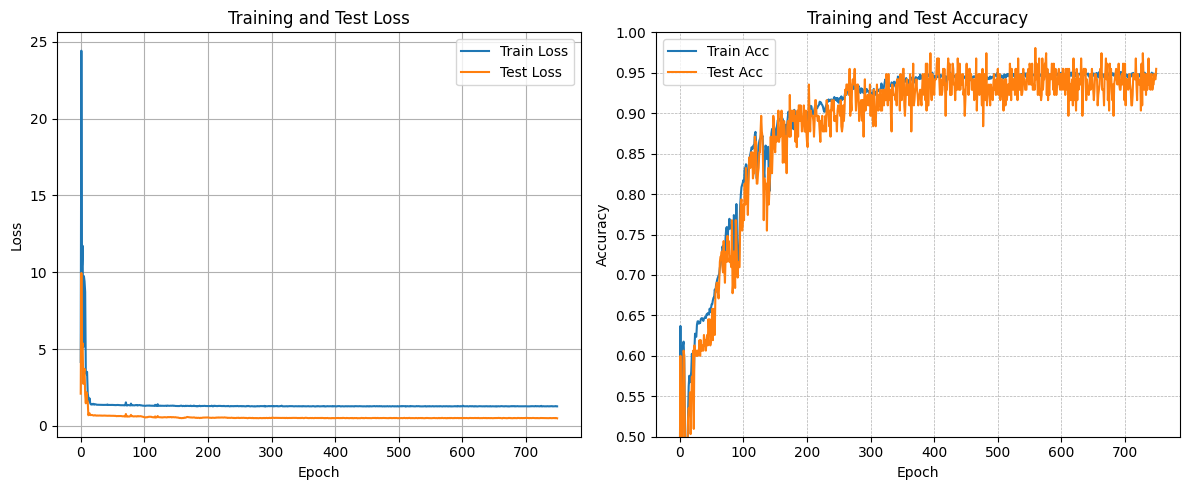


Red Win Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98        95
         1.0       1.00      0.93      0.97        60

    accuracy                           0.97       155
   macro avg       0.98      0.97      0.97       155
weighted avg       0.98      0.97      0.97       155



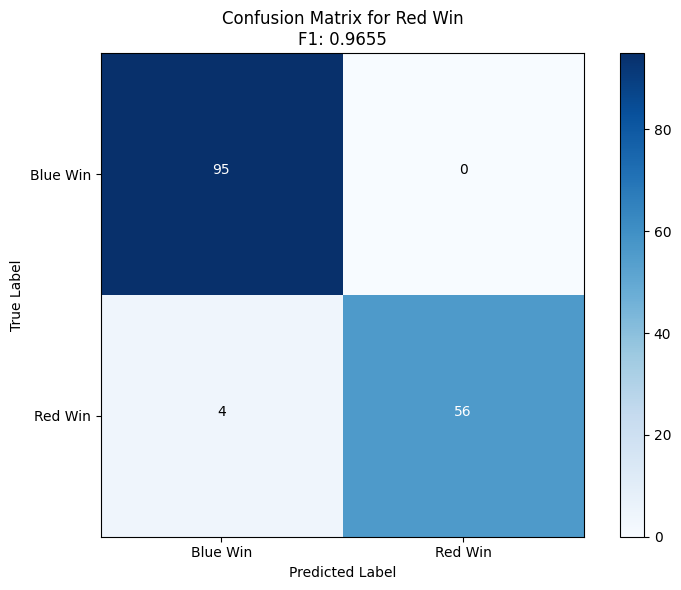

Red prediction function: Average red win probability: 0.3859
Blue prediction function: Average blue win probability: 0.3927


In [33]:
# Initialize the model
model = SymmetricUFCNet(num_edge_features=len(edge_feature_cols), hidden_channels=128)

# Train the model
trained_model, metrics = train_model_single_output(model, data, edge_dates=edge_dates, 
                                                  test_percent=0.01, num_epochs=750, 
                                                  lr=0.01, weight_decay=1e-7)
# Predict with both methods
red_predictions = predict_red_win(trained_model, data, node_idx, validation)
blue_predictions = predict_blue_win(trained_model, data, node_idx, validation) 

# Combine for balanced predictions
combined_predictions = combine_predictions(red_predictions, blue_predictions)

In [34]:
combined_predictions

,red_fighter_name,blue_fighter_name,red_win_prob,blue_win_prob,predicted_winner,winner_name
0,Marvin Vettori,Roman Dolidze,0.387134,0.438732,blue,Roman Dolidze
1,Chidi Njokuani,Elizeu Zaleski dos Santos,0.367111,0.36103,red,Chidi Njokuani
2,Alexander Hernandez,Kurt Holobaugh,0.382444,0.369874,red,Alexander Hernandez
3,Da'Mon Blackshear,Cody Gibson,0.403384,0.370073,red,Da'Mon Blackshear
4,Diyar Nurgozhay,Brendson Ribeiro,None,None,tie,tie
5,SeungWoo Choi,Kevin Vallejos,None,None,tie,tie
6,Waldo Cortes-Acosta,Ryan Spann,0.36163,0.435139,blue,Ryan Spann
7,SuYoung You,AJ Cunningham,0.404015,0.367621,red,SuYoung You
8,Carlos Vera,Josias Musasa,None,None,tie,tie
9,Stephanie Luciano,Sam Hughes,0.395783,0.426996,blue,Sam Hughes
